# 1. Fourier transform

We begin by considering the following signal

$$ x(t) = 5 \sin(2 \pi 10 t) + 3 \sin(2 \pi 400 t)$$

and plot $N = 128$ samples of $x(n)$ by sampling $x(t)$ every $T_s = 10^{-3}$ seconds.


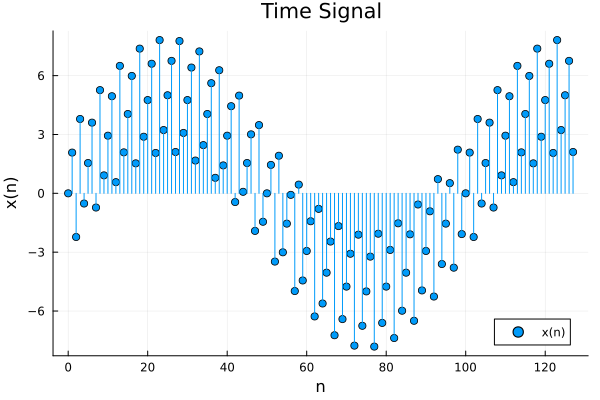

In [1]:
using Plots
Ts = 1e-3
N = 128
t = Ts*(0:N - 1)
x = 5*sin.(2*pi*10*t) + 3*sin.(2*pi*400*t)
plot(0:N-1,x,label = "x(n)",title = "Time Signal" ,xlabel = "n", ylabel = "x(n)",line=:stem, marker=:circle)

The Fourier transform is the mathematical process that transforms a given function to an expression that describes its consituent frequencies. This function is usually a (periodic) signal and the counterpart for a discrete time signal, like the one above, is known as the discrete Fourier transform (DFT) and is defined in the following manner:

Let $x(n)$ be a periodic sequence with period $N$. It can be decomposed in as a sum of $N$ harmonics:
$$ e_k(n) = e^{j 2 \pi \frac{k}{N}n}, \quad k = 0,\dots , N-1 $$

as:

$$ x(n) = \frac{1}{N}\sum_{k=0}^{N-1} X(k)e^{j 2 \pi \frac{k}{N}n} $$

which implies that
$$ X(k) =  \sum_{k=0}^{N-1} x(n)e^{-j 2 \pi \frac{k}{N}n}$$

A function like the one below performs the DFT of a given input 


In [2]:
"""
compute the DFT of x
"""
function dft(x)
    n = length(x)
    X = zeros(Complex{Float64}, n)        
    for k in 1:n                
        expfactor = exp(-im*2*pi/n)           
        X[k] = 0.0                          
        for q in 1:n
            X[k] += x[q]*expfactor^((k-1)*(q-1))
        end
    end
    return X
end;

We use the function above to compute the DFT of the signal we started with. As the output is a complex vector, in order to visualize the result, we will compute the square modulus of the output and also use the built in function $\texttt{fftshift}$ to center the output on $0$. We also choose to plot from $-\frac{1}{2}f_s$ to $+\frac{1}{2}f_s$, where $f_s$ is the frequency plane period corresponding to our sampling frequency $T_s$


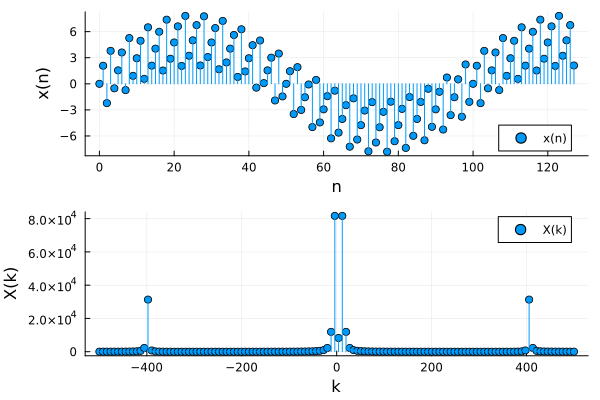

In [3]:
using FFTW
X = fftshift(abs2.(dft(x)))
frequency_plane = LinRange(-1/(2*Ts),1/(2*Ts),N)
p1 = plot(0:N-1, x, label = "x(n)" , xlabel = "n" , ylabel = "x(n)",line=:stem, marker=:circle)
p2 = plot(frequency_plane,X,label = "X(k)" , xlabel = "k" , ylabel = "X(k)",line=:stem, marker=:circle)
plot(p1,p2,layout=(2,1))


We can clearly see the 2 frequencies of the cosine on the graph below as delta functions centered at $\pm 10$ and $\pm 400$

Let's take a closer look to the DFT of a similar signal

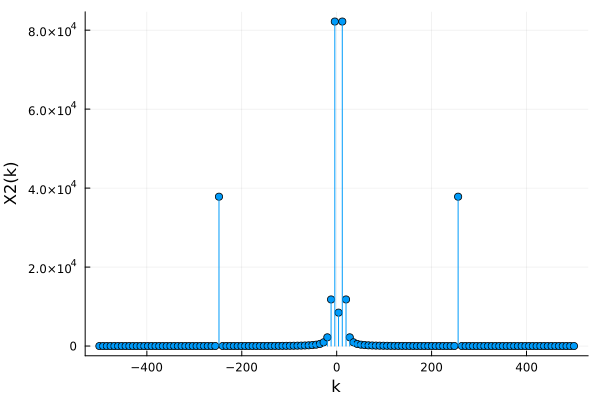

In [4]:
x2 = 5*sin.(2*pi*10*t) + 3*sin.(2*pi*750*t)
X2 = fftshift(abs2.(dft(x2)))
p3 = plot(frequency_plane, X2, label = "" , xlabel = "k" , ylabel = "X2(k)",line=:stem, marker=:circle)


The issue is that our sampling frequency is not at least twice as big as the maximum frequency of the provided singal ($750\text{ Hz}$) and therefore this frequency is not visible in the Fourier domain.

# 2.DFT and FFT
In this section we will study the fast Fourier transform. The FFT is an algorithm that computes the DFT of a given signal by splitting the transform in even and odd terms, greatly improving the computational efficiency and reducing the time of computation.

$$ X(k) = \underbrace{\sum_{r=0}^{N/2-1} x(2r)e^{j 2 \pi \frac{k}{N/2}r}}_\text{DFT of even samples}  + e^{j 2 \pi \frac{k}{N}} \underbrace{\sum_{r=0}^{N/2-1} x(2r)e^{j 2 \pi \frac{k}{N/2}r}}_\text{DFT of odd samples} $$

By performing the FFT on the first signal we defined as $$ x(t) = 5 \sin(2 \pi 10 t) + 3 \sin(2 \pi 400 t)$$
we get exactly the same result when applying the classic DFT with the function we defined, as it can be seen from the graph below, where the matrix $|X(k)_{FFT} - X(k)_{DFT}|$ is compared to the frequency spectrum $X(k)_{DFT}$


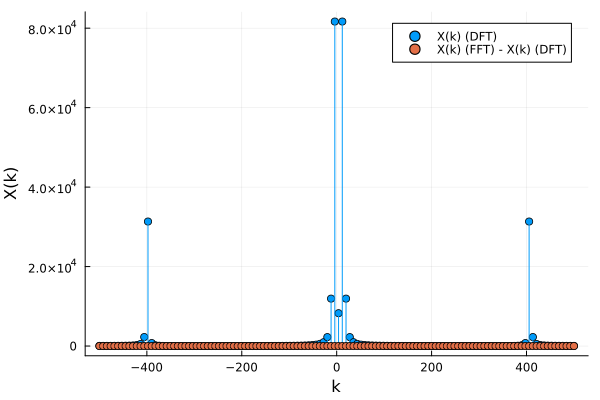

In [5]:
fastX = fftshift(abs2.(fft(x)))
dif = abs.(fastX - X)
p5 =  plot(frequency_plane,[X,dif],label = ["X(k) (DFT)" "X(k) (FFT) - X(k) (DFT)"] , xlabel = "k" , ylabel = "X(k)",line=:stem, marker=:circle)

Now, we will introduce a signal with a large number of samples in order to verify the difference in computational time between the 2 methods. The number of samples is $2^{10}$ and the signal is $$ x(n) = \cos(2 \pi (11/N_b)n)\quad n = 0, \dots, N_b-1 $$

In [6]:
N_b = 2^10
n = (0:N_b-1)
x = cos.(2*pi*(11/N_b)n);
@time dft(x);
@time fft(x);

  0.097038 seconds (1 allocation: 16.125 KiB)
  0.000074 seconds (6 allocations: 32.547 KiB)


We can see that the difference in the computational time of this example is around 4 orders of magnitude

In the general case where $x(n) = \cos(2 \pi (n_0/N) n)$, its DFT is calculated like:
$$ X(k) =  \sum_{n=0}^{N-1} x(n)e^{-j 2 \pi \frac{k}{N}n} = \sum_{n=0}^{N-1} \cos(2 \pi (n_0/N)n)e^{-j 2 \pi \frac{k}{N}n} $$
and by using the fact that
$$ \cos x = \frac{e^{jx} + e^{-jx}}{2}  $$
we deduce that:
$$\sum_{n=0}^{N-1} \cos(2 \pi n_0/N)ne^{-j 2 \pi \frac{k}{N}n} = \frac{1}{2} \sum_{n=0}^{N-1} (e^{-j 2 \pi \frac{n_0}{N}n} + e^{j 2 \pi \frac{n_0}{N}n} ) e^{-j 2 \pi \frac{k}{N}n} = $$
$$ \frac{1}{2}\underbrace{\left(\sum_{n=0}^{N-1}e^{-j 2 \pi \frac{n_0}{N}n} e^{-j 2 \pi \frac{k}{N}n} + \sum_{n=0}^{N-1}e^{j 2 \pi \frac{n_0}{N}n} e^{-j 2 \pi \frac{k}{N}n} \right)}_\text{DFTs of $e^{\pm j 2 \pi \frac{n_0}{N}n}$} =$$
$$ \frac{1}{2}\left( \delta\left(k + \frac{n_0}{N}\right) + \delta\left(k - \frac{n_0}{N}\right) \right) $$


We can confirm this by numerically calculating the DFT for $N = 2^4$ and $n_0 = 3$. We can see that the amplitude is indeed $1/2$, if we normalize

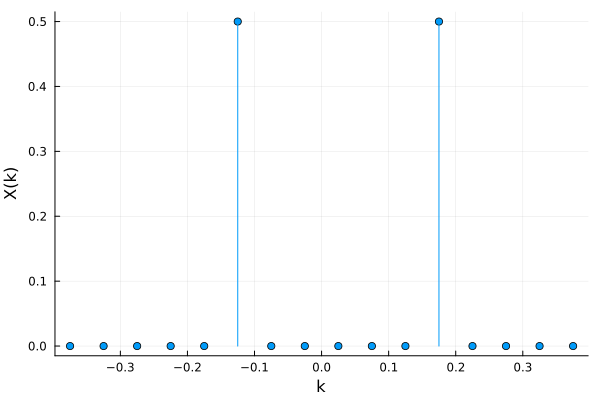

In [7]:
N = 2^4
n_0 = 3
n = (0:N - 1)
f_0 = n_0/N
x = cos.(2*pi*f_0*n);
frequency_plane = LinRange(-2*f_0, 2*f_0, N)
X = 1/N*fftshift(abs.(fft(x)))
p6 =  plot(frequency_plane, X,label = "" , xlabel = "k" , ylabel = "X(k)",line=:stem, marker=:circle)


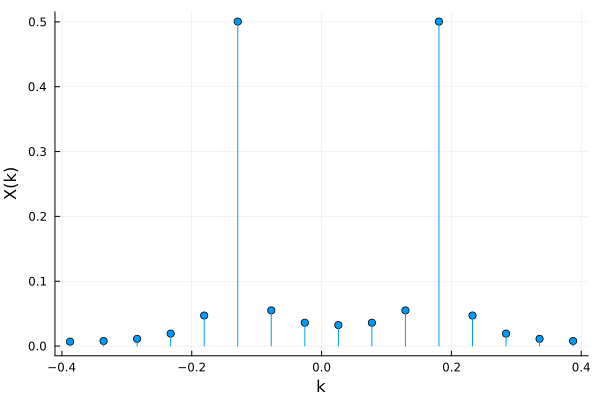

In [8]:
N = 2^4
n_0 = 3.1
n = (0:N - 1)
f_0 = n_0/N
x = cos.(2*pi*f_0*n);
frequency_plane = LinRange(-2*f_0, 2*f_0, N)
X = 1/N*fftshift(abs.(fft(x)))
p7 =  plot(frequency_plane, X,label = "" , xlabel = "k" , ylabel = "X(k)",line=:stem, marker=:circle)


Zero-padding is the process of appending zeros at a given signal to reach a desired length. The DFT in that case will take the following form, in the case where the initial signal was of length $N$ and has been zero-padded to length $M$:
$$ X(k) = \underbrace{\sum_{n=0}^{N-1} x(n)e^{-j 2 \pi \frac{k}{N}n}}_\text{Length $N$} \xrightarrow[]{zero-padding} X'(k) = \underbrace{\sum_{n=0}^{M-1} x'(n)e^{-j 2 \pi \frac{k}{M}n}}_\text{Length $M$}  $$

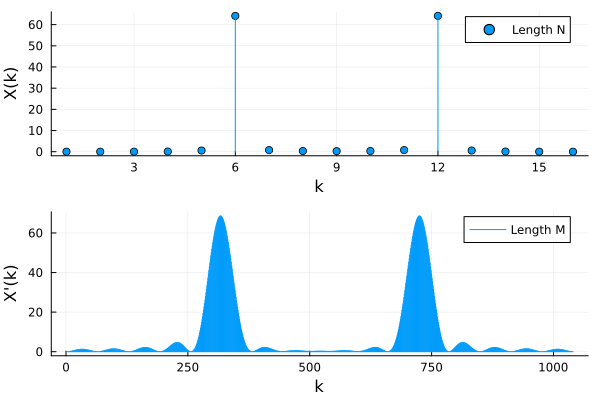

In [9]:
N = 2^4
n_0 = 3.1
n = (0:N - 1)
f_0 = n_0/N
x = cos.(2*pi*f_0*n);
frequency_plane = LinRange(-2*f_0, 2*f_0, N)
X = fftshift(abs2.(fft(x)))
x_prime = [x;zeros(2^10)]
X_prime = fftshift(abs2.(fft(x_prime)))
p8 = plot( X, label = "Length N" , xlabel = "k" , ylabel = "X(k)",line=:stem, marker=:circle)
p9 = plot(X_prime,label = "Length M" , xlabel = "k" , ylabel = "X'(k)",line=:stem)
plot(p8,p9,layout=(2,1))

It is evident that by performing this zero-padding operation, the resolution of the DFT is increased

# 3.1 Convolution

1. We begin by writing down our signal and our impulse response:
$$ x = [1,2,3,4], \quad h = [3,1] $$

2. We have to pad our signal $x$ in order to proceed with the convolution
$$x = [0,1,2,3,4,0]$$

3. The convolution is given by 
$$ y(n) = x(n)*h(n) = \sum_{k=-\infty}^{\infty} x(n)h(n-k) $$
therefore:
$$ y(-1) = x(-1)\times h(-1) + x(0) \times h(0) = 0 \times 1 + 1 \times 3 = 3 $$
$$ y(0) = x(0)\times h(0) + x(1) \times h(1) = 1 \times 1 + 2 \times 3 = 7 $$
$$ y(1) = x(1)\times h(1) + x(2) \times h(2) = 2 \times 1 + 3 \times 3 = 11 $$
$$ y(2) = x(2)\times h(2) + x(3) \times h(3) = 3 \times 1 + 4 \times 3 = 15 $$
$$ y(3) = x(3)\times h(3) + x(4) \times h(4) = 4 \times 1 + 0 \times 3 = 4 $$
such that
$$ x(-1) = x(4) = 0 $$

Using the convolution function provided by the DSP package we verify the above

In [10]:
using DSP
x = [1,2,3,4]
h = [3,1]
y = conv(x,h)

5-element Vector{Int64}:
  3
  7
 11
 15
  4

The circular convolution is the equivalent to the linear convolution but instead of zero-padding we use signal replications. By defintion:
$$ y(n) = x(n)*_Nh(n) = \sum_{m=0}^{N-1} \tilde{x}(m)\tilde{h}(n-m) \quad \text{  for  } \quad 0 \leq n \leq N-1 $$
$$ y(n) = 0 \quad \text{otherwise} $$

If $Y(k)$, $X(k)$ and $H(k)$ are the DFTs of of $y(n)$, $x(n)$ and $h(n)$ respectively, then:
$$ Y(k) = X(k)H(k) $$
and $y(n)$ can be computed by inverse Fourier transform

Let's compute a circular convolution:

In [11]:
x = [1,2,3,4]
h = [3,2,1,0]
X = fft(x)
H = fft(h)
Y = X.*H
y = ifft(Y)


4-element Vector{ComplexF64}:
 14.0 + 0.0im
 12.0 + 0.0im
 14.0 + 0.0im
 20.0 + 0.0im

We note that the 2 signals being circularly convoluted need to be of the same length